In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.linalg import hankel
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyo

# 定义SSA类,用于时间序列的奇异谱分析
class SSA:
    def __init__(self, window_size, time_series_length=None):
        """
        初始化SSA类
        :param window_size: 窗口大小,用于生成Hankel矩阵
        :param time_series_length: 时间序列的长度(可选)
        """
        self.window_size = window_size

    def decompose(self, time_series):
        """
        对时间序列进行分解
        :param time_series: 输入的时间序列
        :return: 奇异值分解的U, s, Vt矩阵
        """
        N = len(time_series)
        K = N - self.window_size + 1
        # 构造Hankel矩阵
        X = hankel(time_series[:K], time_series[K - 1:])
        # 对Hankel矩阵进行奇异值分解
        U, s, Vt = np.linalg.svd(X, full_matrices=False)
        self.U, self.s, self.Vt = U, s, Vt
        self.X = X
        return U, s, Vt

    def reconstruct(self, components):
        """
        根据选定的主成分进行重构
        :param components: 选定的主成分索引列表
        :return: 重构后的时间序列
        """
        # 重构Hankel矩阵
        X_reconstructed = sum(self.s[comp] * np.outer(self.U[:, comp], self.Vt[comp, :]) for comp in components)
        # 还原时间序列
        trajectory = np.zeros(len(self.X) + self.window_size - 1)
        weight = np.zeros(len(self.X) + self.window_size - 1)
        for i in range(X_reconstructed.shape[0]):
            trajectory[i:i + self.window_size] += X_reconstructed[i, :]
            weight[i:i + self.window_size] += 1
        return trajectory / weight

# 自动选择主成分函数
def select_components(s, threshold=0.9):
    """
    根据累积贡献率选择主成分
    :param s: 奇异值向量
    :param threshold: 累积贡献率的阈值(默认值为0.9)
    :return: 选定的主成分索引
    """
    explained_variance = np.cumsum(s**2) / np.sum(s**2)
    components = np.where(explained_variance <= threshold)[0]
    return components

# 特征工程函数
def create_features(data, lag, step=1):
    """
    创建特征和目标变量
    :param data: 输入的时间序列数据
    :param lag: 滞后阶数
    :param step: 预测步长(默认值为1)
    :return: 特征矩阵X和目标变量y
    """
    X, y = [], []
    for i in range(0, len(data) - lag - step + 1, step):
        X.append(data[i:i + lag])
        y.append(data[i + lag:i + lag + step])
    return np.array(X), np.array(y)

# 加载并预处理数据
data = pd.read_csv('./data/total_load_actual.csv')  # 加载CSV文件
if data.isnull().any().any():
    data = data.ffill()  # 填充缺失值

total_actual_load_list = data['total load actual'].tolist()  # 提取时间序列数据

# 数据标准化
scaler = MinMaxScaler(feature_range=(0, 1))  # 创建标准化器
# 对时间序列数据进行缩放
total_actual_load_list_scaled = scaler.fit_transform(np.array(total_actual_load_list).reshape(-1, 1)).flatten()
time_series = total_actual_load_list_scaled

# SSA分解和重构
window_size = 8  # 设置窗口大小
ssa = SSA(window_size, time_series_length=len(time_series))
U, s, Vt = ssa.decompose(time_series)  # 分解时间序列

components = select_components(s, threshold=0.99)  # 自动选择主成分
reconstructed_series = ssa.reconstruct(components)  # 使用选定主成分重构时间序列

# 创建特征和目标变量
lag = 20  # 滞后阶数
X, y = create_features(reconstructed_series, lag)  # 生成特征矩阵和目标变量

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 按8:2划分数据

# 特征和目标变量的标准化
scaler_X = MinMaxScaler()  # 创建特征标准化器
scaler_y = MinMaxScaler()  # 创建目标变量标准化器

X_train_scaled = scaler_X.fit_transform(X_train)  # 标准化训练特征
X_test_scaled = scaler_X.transform(X_test)  # 标准化测试特征

y_train_scaled = scaler_y.fit_transform(y_train)  # 标准化训练目标变量
y_test_scaled = scaler_y.transform(y_test)  # 标准化测试目标变量

# 使用xgb.train()方法训练模型
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_scaled.ravel())  # 创建训练数据矩阵
dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled.ravel())  # 创建测试数据矩阵

params = {
    'objective': 'reg:squarederror',  # 回归目标
    'max_depth': 3,  # 树的最大深度
    'learning_rate': 0.1,  # 学习率
    'random_state': 42,  # 随机种子
    'eval_metric': 'rmse'  # 评估指标为RMSE
}

num_boost_round = 100  # 设置迭代次数

evals_result = {}  # 存储评估结果
model = xgb.train(params, dtrain, num_boost_round,
                  evals=[(dtrain, 'train'), (dtest, 'test')],
                  evals_result=evals_result,
                  verbose_eval=False)  # 训练模型

train_losses = evals_result['train']['rmse']  # 提取训练集上的RMSE


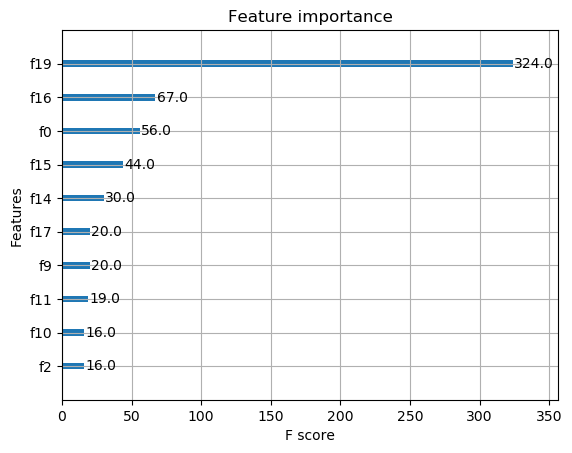

In [2]:
# 绘制特征重要性
xgb.plot_importance(model, importance_type='weight', max_num_features=10)
plt.show()

In [3]:

# 进行预测
y_pred_scaled = model.predict(dtest)

# 反标准化预测值和真实值
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_true = scaler_y.inverse_transform(y_test_scaled).flatten()

# 由于进行了两次标准化,需要对预测值和真实值进行两次反向转换
y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_inverse = scaler.inverse_transform(y_test_true.reshape(-1, 1)).flatten()

# 计算指标
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(mse)
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
    return mse, mae, mape, rmse, r2, smape

# 计算归一化尺度的指标
mse_normalized, mae_normalized, mape_normalized, rmse_normalized, r2_normalized, smape_normalized = calculate_metrics(y_test_scaled.flatten(), y_pred_scaled)

# 计算原始尺度的指标
mse_original, mae_original, mape_original, rmse_original, r2_original, smape_original = calculate_metrics(y_test_inverse, y_pred_inverse)

# 打印指标表格
print('+----------------------+-----------------------+----------------------+-----------------------+')
print('|   Metrics            |   Original Scale      |   Normalized Scale   |')
print('+----------------------+-----------------------+----------------------+-----------------------+')
metrics = [
    ('MSE', mse_original, mse_normalized),
    ('MAE', mae_original, mae_normalized),
    ('MAPE', mape_original, mape_normalized),
    ('RMSE', rmse_original, rmse_normalized),
    ('R²', r2_original, r2_normalized),
    ('SMAPE', smape_original, smape_normalized)
]

for metric, original_value, normalized_value in metrics:
    print(f'| {metric:<20} | {original_value:>20.6f} | {normalized_value:>20.6f} |')

print('+----------------------+-----------------------+----------------------+-----------------------+')


+----------------------+-----------------------+----------------------+-----------------------+
|   Metrics            |   Original Scale      |   Normalized Scale   |
+----------------------+-----------------------+----------------------+-----------------------+
| MSE                  |         44460.508144 |             0.000112 |
| MAE                  |           160.905293 |             0.008085 |
| MAPE                 |             0.570705 |             2.210392 |
| RMSE                 |           210.856606 |             0.010595 |
| R²                   |             0.996299 |             0.996299 |
| SMAPE                |             0.005709 |             0.021690 |
+----------------------+-----------------------+----------------------+-----------------------+


In [4]:
# 1. 可视化损失函数下降趋势 

# 可视化预测与实际值
TrainlenthToShow = len(train_losses)

train_loss_curve = go.Scatter(
    x=list(range(TrainlenthToShow)),
    y=train_losses[:TrainlenthToShow],
    mode='lines+markers',
    name='Train',
    line=dict(color='#36A2EB', width=3, shape='spline'),
    marker=dict(symbol='circle', size=5, color='rgba(0,0,0,0)', line=dict(color='#36A2EB', width=2))
)

train_loss_fig = go.Figure(data=train_loss_curve)

train_loss_fig.update_layout(
    title='XGBoost-SSA: Train Loss Curve',
    title_font=dict(size=20, family='Times New Roman', color='black'),
    xaxis=dict(title='Time Step', title_font=dict(size=14, family='Times New Roman', color='black'), gridcolor='lightgray'),
    yaxis=dict(title='Load', title_font=dict(size=14, family='Times New Roman', color='black'), gridcolor='lightgray'),
    plot_bgcolor='whitesmoke',
    paper_bgcolor='whitesmoke',
    font=dict(family='Times New Roman', size=12, color='black'),
    legend=dict(x=0.5, y=1.1, xanchor='center', orientation='h', traceorder='normal',
                font=dict(family='Times New Roman', size=12, color='black'),
                bgcolor='rgba(255, 255, 255, 0.5)', bordercolor='black', borderwidth=1),
    showlegend=True
)

train_loss_fig.update_layout(paper_bgcolor='rgba(240, 240, 240, 0.9)', plot_bgcolor='rgba(255, 255, 255, 0.9)', width=1200, height=600)

train_loss_fig.show()

#2. 可视化预测与实际值
TestlenthToShow = 100

actual_trace = go.Scatter(
    x=list(range(TestlenthToShow)),
    y=y_test_inverse[:TestlenthToShow].flatten(),
    mode='lines+markers',
    name='Actual',
    line=dict(color='#FF6347', width=3, shape='spline'), # spline会进行插值 让它看起来平滑
    marker=dict(symbol='circle', size=5, color='rgba(0,0,0,0)', line=dict(color='#FF0000', width=2))
)

predicted_trace = go.Scatter(
    x=list(range(TestlenthToShow)),
    y=y_pred_inverse[:TestlenthToShow].flatten(),
    mode='lines+markers',
    name='Predicted',
    line=dict(color='#36A2EB', width=3, dash='dot', shape='spline'),
    marker=dict(symbol='x', size=5, color='rgba(0,0,0,0)', line=dict(color='#007bff', width=2))
)

comparison_fig = go.Figure(data=[actual_trace, predicted_trace])

comparison_fig.update_layout(
    title='XGBoost-SSA: Actual vs Predicted',
    title_font=dict(size=20, family='Times New Roman', color='black'),
    xaxis=dict(title='Time Step', title_font=dict(size=14, family='Times New Roman', color='black'), gridcolor='lightgray'),
    yaxis=dict(title='Load', title_font=dict(size=14, family='Times New Roman', color='black'), gridcolor='lightgray'),
    plot_bgcolor='whitesmoke',
    paper_bgcolor='whitesmoke',
    font=dict(family='Times New Roman', size=12, color='black'),
    legend=dict(x=0.5, y=1.1, xanchor='center', orientation='h', traceorder='normal',
                font=dict(family='Times New Roman', size=12, color='black'),
                bgcolor='rgba(255, 255, 255, 0.5)', bordercolor='black', borderwidth=1),
    showlegend=True
)

comparison_fig.update_layout(paper_bgcolor='rgba(240, 240, 240, 0.9)', plot_bgcolor='rgba(255, 255, 255, 0.9)', width=1200, height=600)

comparison_fig.show()